# Redução da frequência de amostragem

fs do sinal ecg_lfn = 1000 Hz

Pretende-se reduzir a fs para 300 Hz

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

import scipy.signal as ss
from scipy.signal import freqz, butter, lfilter #scipy conjunto de packs para calculo cientifico

## Sistema que reduz a fs = 1000 Hz para fs = 300 Hz

O sinal ecg_lfn inicialmente é filtrado por um filtro FIR passa-alto, para eliminar as frequencias inferiores a 2 Hz

De seguida entra num sistema constituido por dois blocos. O primeiro bloco é o responsável por aumentar a taxa de amostragem de 1000 Hz para 3000 Hz (upsampling). O segundo bloco diminui a taxa de amostragem de 3000 Hz para 300 Hz (downsampling).

### Sinal corrompido e sinal filtrado

9519

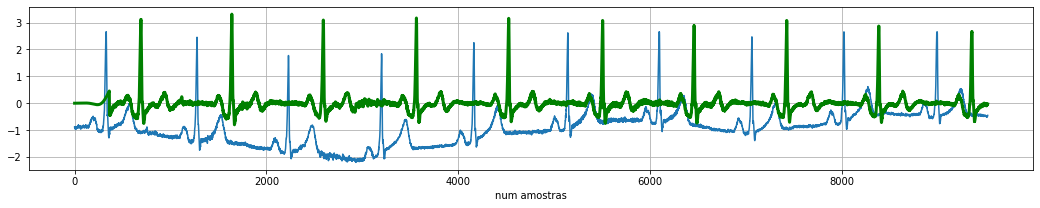

In [8]:
data = np.loadtxt('ecg_lfn.dat')

fs = 1000  # frequencia de amostragem
nyquist = fs / 2.0
high_cut = 4
high = high_cut / nyquist # normalizada
width = 5 / nyquist # largura -> normalizada - banda de transição
ripple_db = 60.0   # ripple -> 

num_taps, beta = ss.kaiserord(ripple_db, width)
taps = ss.firwin(num_taps, high, window=('kaiser', beta), pass_zero='highpass') # calculo os coeficientes -> taps
s_filtered = ss.lfilter(taps, 1.0, data) # filtro o meu sinal

plt.figure(figsize=(18, 3))
plt.grid(True)
plt.xlabel('num amostras')
plt.plot(data)
_ = plt.plot(s_filtered, 'g', linewidth=3)
len(s_filtered)

A azul é possível ver o sinal original, corrompido. A verde o sinal na saída do filtro FIR passa-alto, com as frequencias inferiores a 2 Hz eliminadas

In [3]:
def butter_lowpass(low_cut, fs, order=5): # low_cut frequencia de corte  da freq analogica em hertz e a ordem do meu filtro : 5
    '''Nota: a função butter assume que a frequência de corte da especificação foi
    normalizada pela frequência de Nyquist'''
    nyquist = 0.5 * fs # freq nyquist é metade da freq de amostragem 
    low = low_cut / nyquist #normalizar em que a frequencia em pi = 1. low é digital e normalizada em pi que vale 1. freq correta = 1 * pi
    b, a = butter(order, low, btype='low') # butter -> calcula se eu der a ordem e a freq de corte e o tipo(low) ele retorna o b e a (butter?) em que b e a sao coeficientes do polinomio do numerador e denominador de H(z) ou H(s) -> depende, se tou a definir a freq do meu filtro anal ou digital
    return b, a

def butter_low_filter(sinal, low_cut, fs, order=5):
    b, a = butter_lowpass(low_cut, fs, order=order)
    y = lfilter(b, a, sinal) # passo o meu polinomio e o sinal entrada e implementa o filtro, dá o sinal filtrado
    return y

### Primeiro Bloco - Aumento da frequência de amostragem (upsampling + interpolação)

Este primeiro bloco aumenta a taxa de amostragem de 1000 Hz para 3000 Hz

Para tal, inicialmente, a cada amostra original é acrescentado 2 zeros (L=3). De seguida, através de um filtro IIR passa-baixo com wc = pi/L e ordem 9, é realizado a interpolação, reconstituindo o sinal com o tripo das amostras. 

In [4]:
def upsampling(low_cut, fs, order, L, s):
    sinal = np.array(s)
    
    padding = np.zeros(L*len(s), dtype=sinal.dtype)
    padding[::L] = sinal # de 3 em 3 vou colocar um original
    
    sinal_inter = butter_low_filter(padding, low_cut, fs, order)
    return L*sinal_inter

# retorna L, devido ao ganho

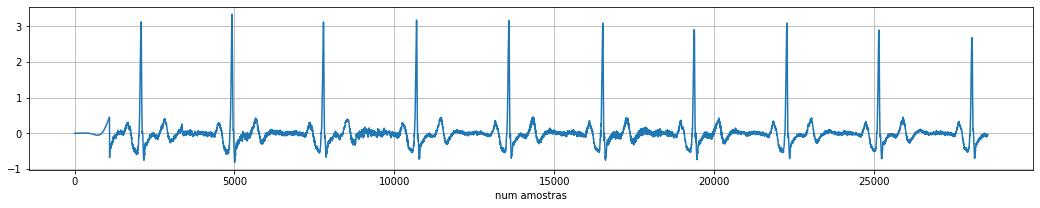

In [10]:
L = 3
fs_upsampling = 1000 * L
low_cut_upsampling = (fs_upsampling * (np.pi/L)) / (2*np.pi)

sinal_upsampling = upsampling(low_cut_upsampling,fs_upsampling,9,L,s_filtered)

plt.figure(figsize=(18, 3))
plt.grid(True)
plt.xlabel('num amostras')
plt.plot(sinal_upsampling)


### Segundo Bloco - Diminuição da frequência de amostragem (downsampling + decimação)

Este segundo bloco diminui a taxa de amostragem de 3000 Hz para 300 Hz

Para tal, em cada 10 amostras temos que retirar 9 (M=10). No fim de retirar as amostras, é utilizado um filtro passa-baixo IIR com wc=pi/M e ordem 9 para reconstruir o sinal com 1/10 das amostras contidas inicialmente.

In [6]:
def downsampling(low_cut, fs, order, M, s):
    #final = np.array(len(s)/M)
    sinal = butter_low_filter(s, low_cut, fs, order)
    
    final = s[::M]  # só ficam as amostras de 10 em 10 - decimação
    return final

2856

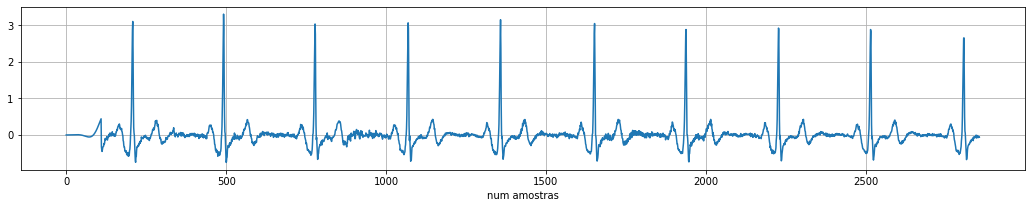

In [11]:
M = 10
fs_downsampling = fs_upsampling / 10  #300
low_cut_upsampling = (fs_downsampling * (np.pi/M)) / (2*np.pi)

#sabes que a freq de amostragem corresponde a 2pi, então x corresponde a pi/L

sinal_downsampling = downsampling(low_cut_upsampling,fs_downsampling,9,M,sinal_upsampling)

plt.figure(figsize=(18, 3))
plt.grid(True)
plt.xlabel('num amostras')
plt.plot(sinal_downsampling)

len(sinal_downsampling)

Através dos dois blocos supra-mencionados, foi possível reduzir a frequencia de amostragem de um sinal de 1000 Hz para 300 Hz, utilizando apenas filtros digitais e as técnicas de downsampling e upsampling.

Deste modo, o sinal, inicialmente filtrado através de um filtro FIR passa-alto, entra no sistema que reduz a sua taxa de amostragem, podendo de seguida, entrar num segundo bloco para o qual foi necessitado.